# Telecom Customer Churn Prediction & Retention Intelligence System

### An end-to-end machine learning workflow to identify at-risk customers, explain churn drivers, and enable targeted retention strategies.

This project follows an industry ML lifecycle including data validation, feature engineering, model evaluation, and deployment readiness.

### Business Understanding
---
1. What does Churn mean in this dataset?

In this dataset, churn refers to whether *a telecom customer has discontinued the company’s service.*
It is represented as a binary target variable: “Yes” means the customer left, and “No” means the customer stayed.
The goal is to analyze customer behavior, service usage, and billing patterns to understand why customers leave.
This helps the company proactively identify at-risk customers and take retention actions.
Hence, the problem is modeled as a binary classification task in machine learning.

---
2. Why is recall more important than accuracy?

In churn prediction, missing a churn customer is more costly than incorrectly flagging a loyal one.
Accuracy treats both errors equally, but in business they are not equal.
Recall measures how many actual churners we successfully identify, which helps the company take retention action in time.
A model with high accuracy can still miss most churners due to class imbalance.
Therefore, recall is prioritized because it minimizes revenue loss by capturing maximum at-risk customers.

--- 
3. What happens if model predicts wrong?

If the model predicts wrong, there are two possible errors.
If it fails to identify a churner (False Negative), the company may lose that customer and revenue.
If it incorrectly flags a loyal customer as churn (False Positive), the company may offer unnecessary discounts or incentives.
In churn problems, missing a real churner is usually more expensive than offering an unnecessary retention benefit.
That’s why we focus on reducing false negatives using metrics like recall.

In [29]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import shap
import warnings
warnings.filterwarnings("ignore")
shap.initjs()

data = pd.read_csv('Telco-Customer-Churn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [2]:
data.shape

(7043, 21)

In [3]:
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


we can see that `TotalCharges` datatype is `object` so we need to process it.

In [5]:
data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors="coerce")
data["TotalCharges"].isnull().sum()

data["TotalCharges"] = data["TotalCharges"].fillna(0)

From this we can state that, These are customers with:
* tenure = 0
* no billing yet

We cannot drop rows with missing TotalCharges because they represent new customers with zero tenure, not corrupted data.
Since no billing has occurred yet, the logical total charge is zero.
Therefore, we converted the column to numeric and imputed missing values with 0 instead of removing observations.
This preserves data distribution and prevents bias in churn analysis.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
data["customerID"].nunique(), len(data)
# data.duplicated().sum()

(7043, 7043)

Each record corresponds to a unique customer since the number of unique customer IDs equals the total number of rows.
This confirms the dataset is a cross-sectional snapshot rather than a time-series dataset, preventing customer-level data leakage in modeling.

## Exploratory Data Analysis

#### Target Distribution

In [8]:
data["Churn"].value_counts()
data["Churn"].value_counts(normalize=True)*100

Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64

About 26% customers churned indicating moderate class imbalance.

#### Customer Profile Analysis

<Axes: xlabel='Contract', ylabel='count'>

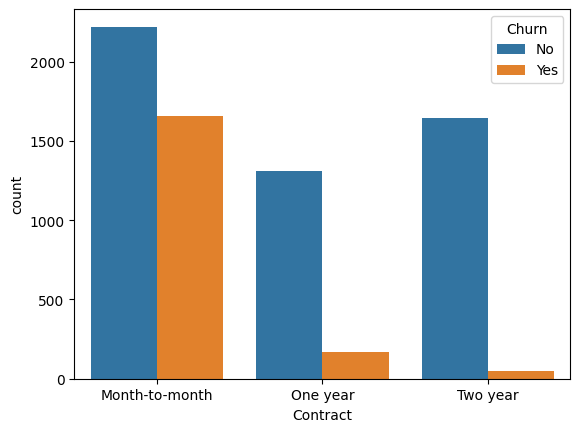

In [9]:
sns.countplot(x="Contract", hue="Churn", data=data)

Customers on month-to-month contracts show significantly higher churn compared to long-term contracts.

<Axes: xlabel='SeniorCitizen', ylabel='count'>

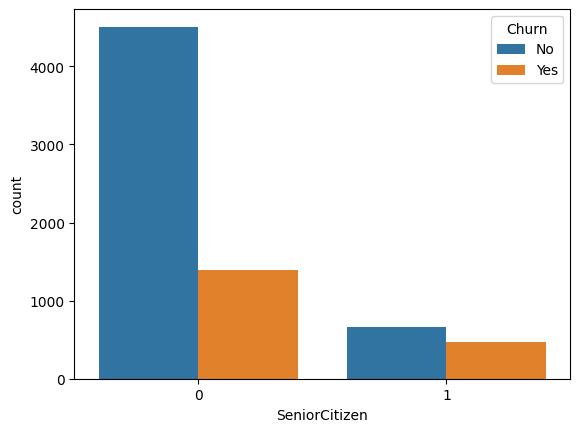

In [10]:
sns.countplot(x="SeniorCitizen", hue="Churn", data=data)

<Axes: xlabel='Partner', ylabel='count'>

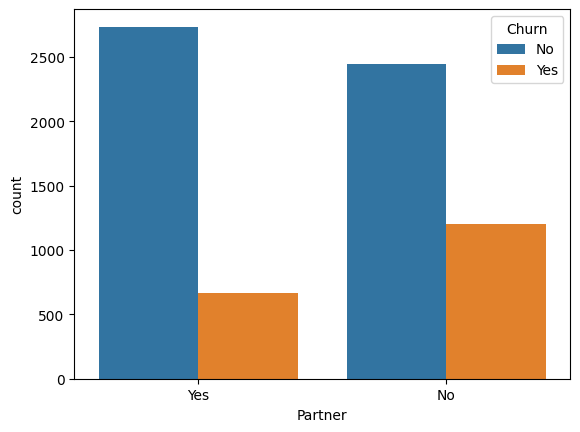

In [11]:
sns.countplot(x="Partner", hue="Churn", data=data)

<Axes: xlabel='Dependents', ylabel='count'>

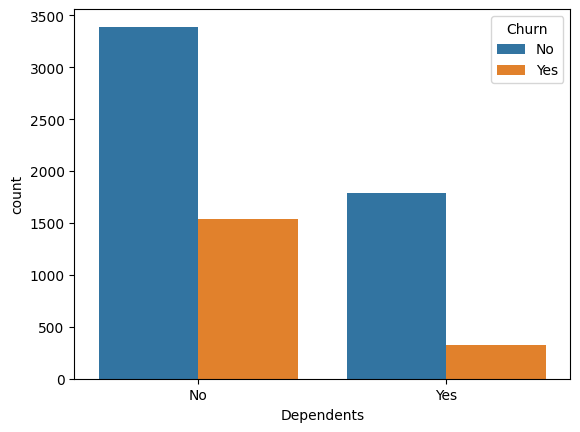

In [12]:
sns.countplot(x="Dependents", hue="Churn", data=data)

#### Service Usage Analysis

<Axes: xlabel='InternetService', ylabel='count'>

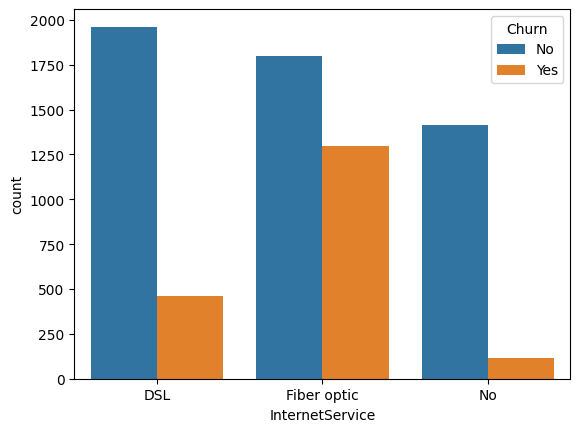

In [13]:
sns.countplot(x="InternetService", hue="Churn", data=data)

<Axes: xlabel='TechSupport', ylabel='count'>

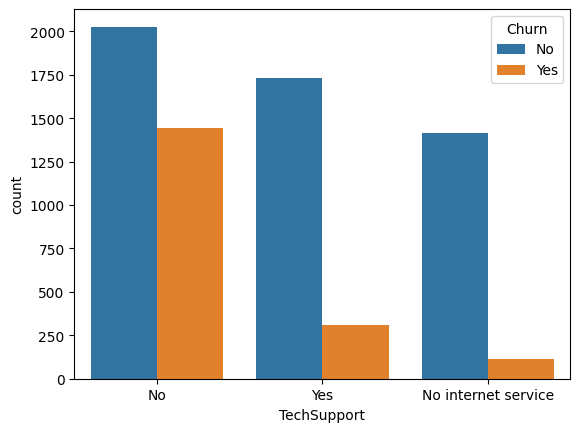

In [14]:
sns.countplot(x="TechSupport", hue="Churn", data=data)

#### Financial Behavior

<Axes: xlabel='Churn', ylabel='MonthlyCharges'>

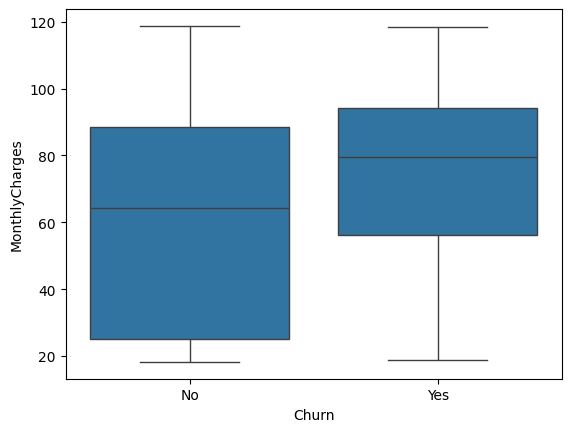

In [15]:
sns.boxplot(x="Churn", y="MonthlyCharges", data=data)

<Axes: xlabel='Churn', ylabel='tenure'>

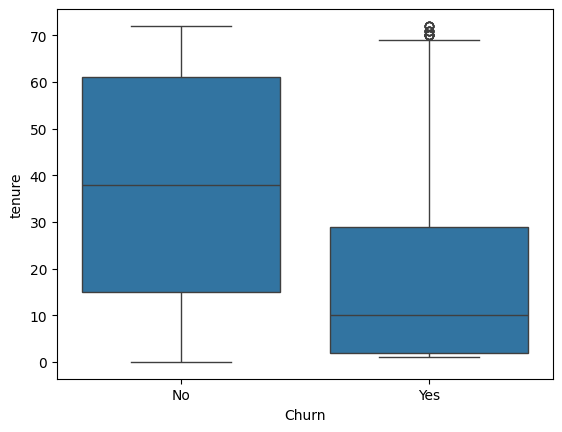

In [16]:
sns.boxplot(x="Churn", y="tenure", data=data)

New customers churn early

<Axes: xlabel='Churn', ylabel='TotalCharges'>

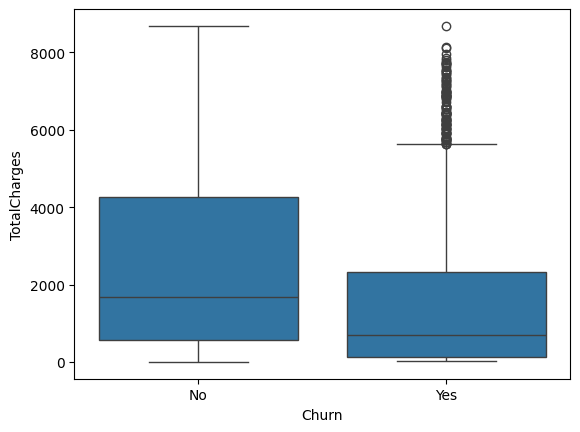

In [17]:
sns.boxplot(x="Churn", y="TotalCharges", data=data)

Customers who churn have significantly lower total charges compared to retained customers.

Low total charges indicate short customer lifetime, suggesting most churn occurs during early subscription stages.

The company should focus retention efforts on new customers during the onboarding period (first few months), such as welcome offers, onboarding support, or early engagement programs.

## Feature Engineering and Preprocessing for Modelling

Business Insights

---

* High churn in month-to-month contracts
* Early tenure customers churn more
* High monthly charges may increase churn
* Lack of tech support increases churn

In [18]:
data.drop("customerID", axis=1, inplace=True)

In [19]:
data["Churn"] = data["Churn"].map({"No":0, "Yes":1})

In [20]:
data = pd.get_dummies(data, drop_first=True)

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          7043 non-null   int64  
 1   tenure                                 7043 non-null   int64  
 2   MonthlyCharges                         7043 non-null   float64
 3   TotalCharges                           7043 non-null   float64
 4   Churn                                  7043 non-null   int64  
 5   gender_Male                            7043 non-null   bool   
 6   Partner_Yes                            7043 non-null   bool   
 7   Dependents_Yes                         7043 non-null   bool   
 8   PhoneService_Yes                       7043 non-null   bool   
 9   MultipleLines_No phone service         7043 non-null   bool   
 10  MultipleLines_Yes                      7043 non-null   bool   
 11  Inte

In [22]:
from sklearn.model_selection import train_test_split

X = data.drop("Churn", axis=1)
y = data["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train_scaled, y_train)

# Predict
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

# Metrics
print("Recall:", recall_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Recall: 0.786096256684492
ROC-AUC: 0.8414012245214291
Confusion Matrix:
[[749 286]
 [ 80 294]]


In [24]:
best_threshold = 0.35
final_pred = (y_prob >= best_threshold).astype(int)

print("Recall (tuned):", recall_score(y_test, final_pred))
print("Confusion Matrix (tuned):")
print(confusion_matrix(y_test, final_pred))

Recall (tuned): 0.9037433155080213
Confusion Matrix (tuned):
[[616 419]
 [ 36 338]]


After training the model, I optimized the decision threshold from 0.5 to 0.35 to align with business goals. This increased churn detection recall to 90%, significantly reducing missed at-risk customers while keeping false positives acceptable.

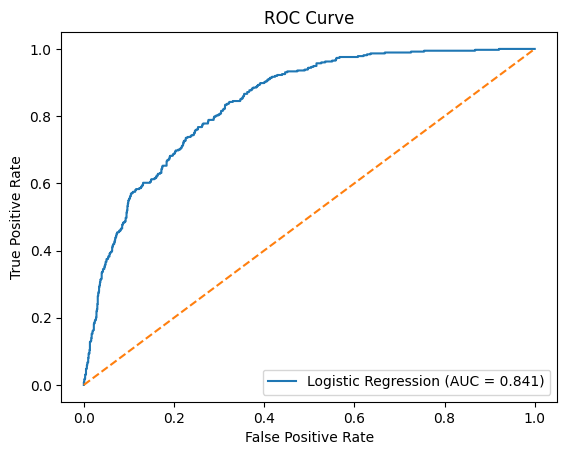

In [25]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr, label="Logistic Regression (AUC = %.3f)" % roc_auc_score(y_test, y_prob))
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [26]:
import pandas as pd

importance = pd.Series(model.coef_[0], index=X_train.columns)
importance = importance.sort_values(key=abs, ascending=False)

print(importance.head(10))

tenure                           -1.159048
MonthlyCharges                   -1.039440
InternetService_Fiber optic       0.808897
Contract_Two year                -0.617746
TotalCharges                      0.494748
Contract_One year                -0.296706
StreamingMovies_Yes               0.285948
StreamingTV_Yes                   0.273209
MultipleLines_Yes                 0.201165
PaymentMethod_Electronic check    0.188783
dtype: float64


Using model coefficients, I identified that commitment-based features reduce churn while convenience-based features increase churn. This allowed translating the ML model into actionable retention strategies.

## Model Explainability

In [39]:
# Convert scaled arrays back to DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df  = pd.DataFrame(X_test_scaled,  columns=X_test.columns)

explainer = shap.LinearExplainer(model, X_train_scaled_df)
shap_values = explainer(X_test_scaled_df)

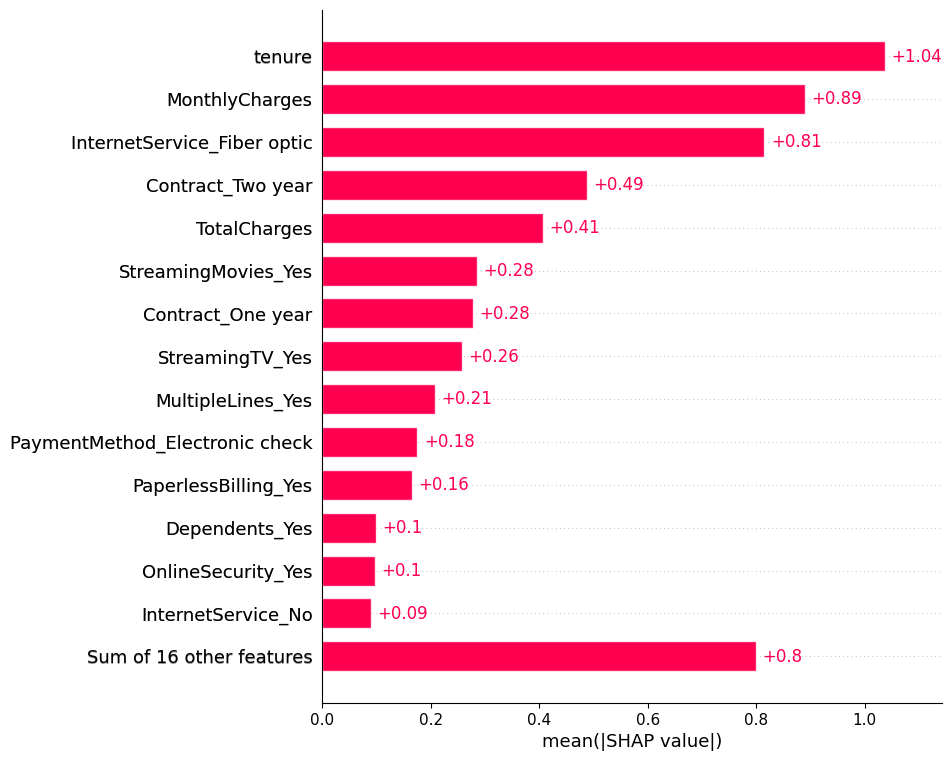

In [40]:
shap.plots.bar(shap_values, max_display=15)

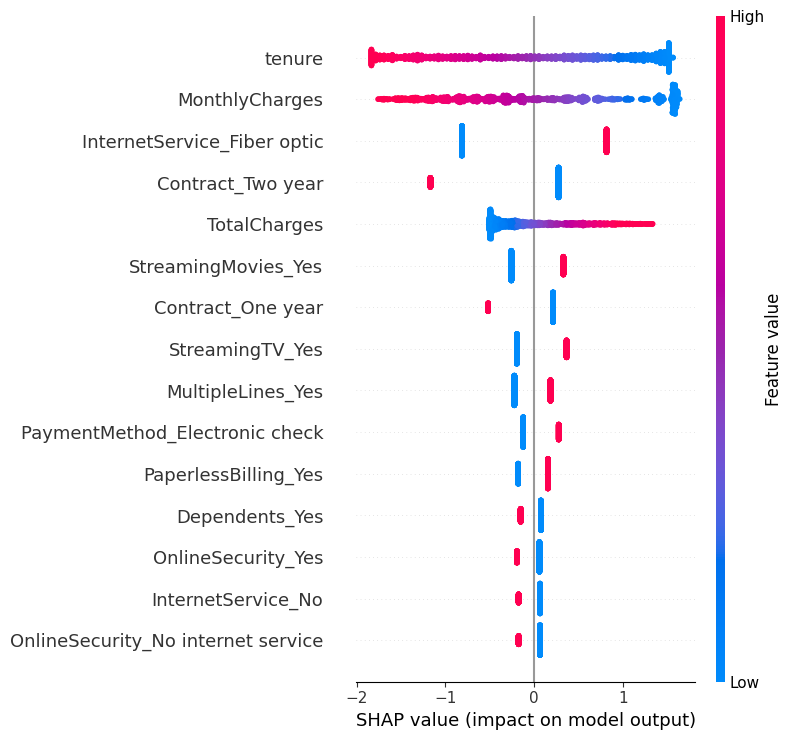

In [45]:
shap.summary_plot(shap_values, X_test_scaled_df, max_display=15)

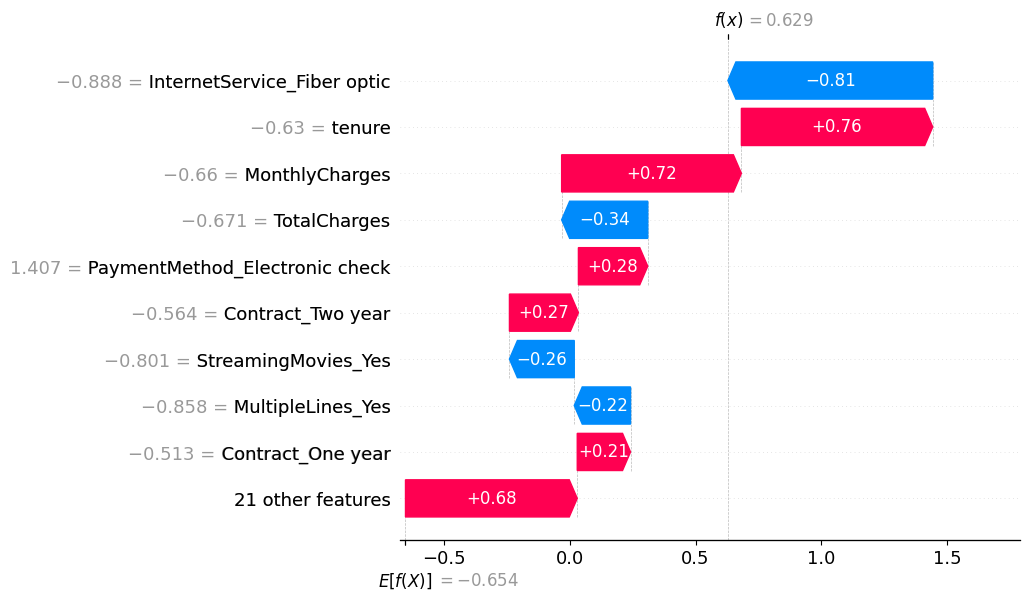

In [42]:
# find a churned user
idx = np.where(y_test == 1)[0][0]

shap.plots.waterfall(shap_values[idx])

In [43]:
shap.plots.force(shap_values[idx])

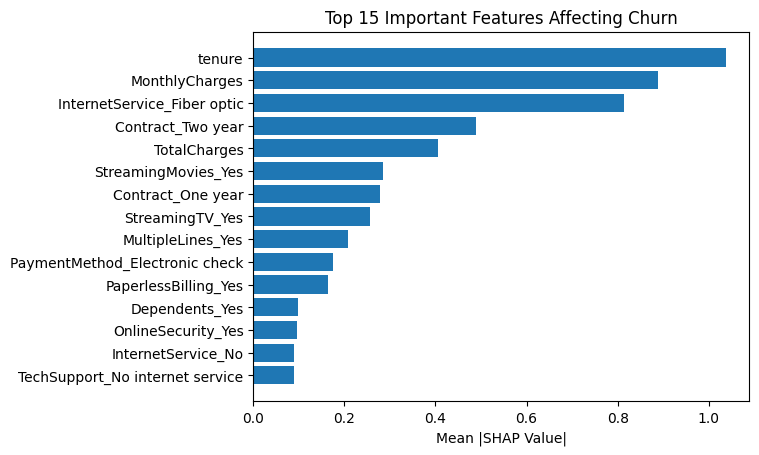

In [49]:
importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": np.abs(shap_values.values).mean(axis=0)
})

importance = importance.sort_values(
    by="Importance", 
    ascending=False
).reset_index(drop=True)

plt.figure()
plt.barh(importance["Feature"][:15], importance["Importance"][:15])
plt.gca().invert_yaxis()
plt.xlabel("Mean |SHAP Value|")
plt.title("Top 15 Important Features Affecting Churn")
plt.show()

SHAP analysis showed that tenure and pricing are the strongest drivers of churn. Customers on month-to-month contracts with high monthly charges and fiber internet are more likely to churn, while long-term contracts significantly reduce churn risk. This helped translate model output into actionable retention strategies.

In [52]:
# =========================
# 1. Import Libraries
# =========================
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression


# =========================
# 2. Identify Feature Types
# =========================
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns


# =========================
# 3. Create Preprocessing Pipeline
# =========================
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", StandardScaler(), numeric_features),
        ("categorical", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features)
    ]
)


# =========================
# 4. Build Final ML Pipeline
# =========================
final_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", LogisticRegression(class_weight="balanced", max_iter=1000))
])


# =========================
# 5. Train Model
# =========================
final_pipeline.fit(X, y)


# =========================
# 6. Save Trained Pipeline
# =========================
joblib.dump(final_pipeline, "churn_pipeline.pkl")

print("Pipeline trained and saved successfully!")

Pipeline trained and saved successfully!
